# Camera position optimization using differentiable rendering


This tutorial demonstrates how to estimate the 3D position of a camera by comparing rendered images with a reference image. The process uses differentiable rendering, which allows gradients to pass from the image space back through the rendering pipeline. This enables the use of optimization algorithms to adjust the camera position so that the rendered image matches the reference.

The goal is to learn the [x, y, z] coordinates of a camera that would generate a silhouette similar to a given image of a teapot. This is done by first rendering the teapot from an initial camera position, computing the difference (loss) between this image and the reference, and then updating the camera position using backpropagation.

To achieve this, we load a 3D mesh, create rendering components including a camera and shaders, generate a reference image from a known position, and set up a model where the camera’s position is treated as a learnable parameter. The optimization loop updates this position to minimize the difference between the rendered and reference silhouettes. The output is a series of improved renderings that show the camera converging to the correct location.

##  Install and import modules¶

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-agi166h8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-agi166h8
  Running command git checkout -q 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.8-cp311-cp311-linux_x86_64.whl size=60242422 sha256=ee574291552bc0abb8ff0eda7960fc5ee3451c56548cc5d788e908aed7a492e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-liwb_tnq/wheels/08/90/1b/df18c3e3634f86278e793b87f37ea4c58d0c36731196122518
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=548168e6e03b21e5a791690

In [ ]:
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

## Load the Obj

In this section, we load a 3D object from an .obj file and prepare it for rendering using PyTorch3D. The .obj file contains the 3D model of a teapot, including its vertex positions and face indices. These are read using the load_obj function. The texture and material data are ignored for simplicity.

Each vertex is then assigned a white color by creating a tensor filled with ones, which represents RGB values. This color information is wrapped in a TexturesVertex object, which allows the renderer to associate color data with each vertex.

Finally, a Meshes object is created. This structure is specific to PyTorch3D and is designed to efficiently handle one or more 3D meshes in a batch. It combines the vertex coordinates, face definitions, and textures into a single object that can be passed into the rendering pipeline. The mesh is moved to the appropriate device, either GPU or CPU, based on availability.

In [ ]:
!mkdir -p data
!wget -P data https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj

--2025-05-01 20:33:02--  https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.111, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152595 (149K) [text/plain]
Saving to: ‘data/teapot.obj’

teapot.obj          100%[===================>] 149.02K  --.-KB/s    in 0.02s   

2025-05-01 20:33:02 (8.47 MB/s) - ‘data/teapot.obj’ saved [152595/152595]



In [ ]:
# Set the cuda device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Load the obj and ignore the textures and materials.
verts, faces_idx, _ = load_obj("./data/teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
teapot_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures
)

/usr/local/lib/python3.11/dist-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


## Optimization setup

### Create a renderer

This part sets up the renderers that will generate images from the 3D mesh. A renderer in PyTorch3D consists of two main parts: a rasterizer, which projects the 3D mesh into 2D pixels, and a shader, which assigns colors to those pixels.

First, a perspective camera is created, which mimics the way a real camera sees objects—closer objects appear larger. The rasterizer is configured to control how many faces contribute to each pixel (faces_per_pixel) and how much blur is applied. For silhouette rendering, a high number of faces per pixel is used along with blending parameters that soften the object’s edges. This renderer, combined with a SoftSilhouetteShader, outputs a grayscale silhouette where white represents object presence and black is background.

A second renderer is created for visualization using Phong shading, which includes lighting effects. This renderer is simpler in terms of rasterization and uses only one face per pixel. A point light is placed in front of the object to simulate illumination. This setup allows rendering a more realistic image of the object with shading and depth, useful for viewing results during optimization.

In [ ]:
# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of
# edges. Refer to blending.py for more details.
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of
# the difference between naive and coarse-to-fine rasterization.
raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
    faces_per_pixel=100,
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader.
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a Phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=0.0,
    faces_per_pixel=1,
)
# We can add a point light in front of the object.
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

### Create a reference image

In this step, we generate a reference image of the teapot from a specific camera viewpoint. This image will serve as the target that the optimization process will try to match.

The camera is positioned using spherical coordinates, defined by distance, elevation, and azimuth. The function look_at_view_transform calculates the rotation (R) and translation (T) matrices needed to place the camera in the scene.

Using these camera parameters, we render the teapot with both the silhouette renderer and the Phong renderer. The silhouette renderer produces an image showing only the object’s outline, while the Phong renderer provides a shaded view. Both images are saved in memory and displayed using matplotlib, showing how the teapot looks from the chosen viewpoint. This is the reference we will try to reproduce by adjusting the camera position.


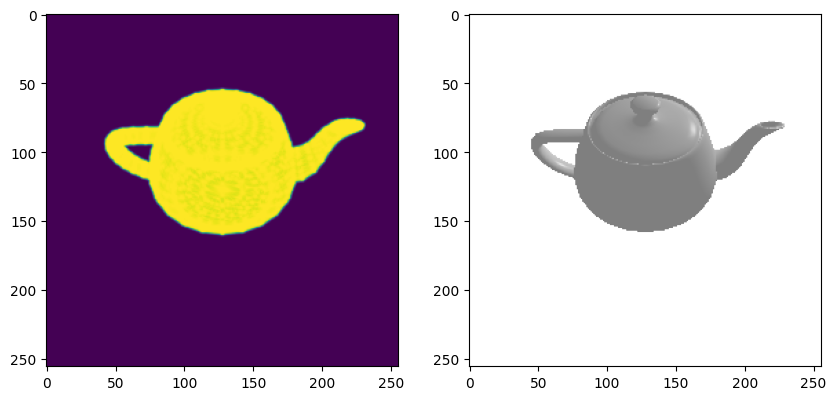

In [ ]:
# Select the viewpoint using spherical angles
distance = 3   # distance from camera to the object
elevation = 50.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis.

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the teapot providing the values of R and T.
silhouette = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouette.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

### Set up a basic model

In this section, we define a neural network model that will learn the optimal camera position. The model is built as a subclass of nn.Module.

In the constructor, we store the input mesh, the renderer, and the device. We also preprocess the reference image by identifying non-white pixels, effectively extracting the silhouette from the RGB reference. This is stored as a fixed buffer so it can be used during training but not updated.

A key part of this model is the learnable camera position, initialized to a fixed [x, y, z] value. This is defined as a nn.Parameter, which means its values will be updated during optimization.

In the forward method, the current camera position is used to compute rotation (R) and translation (T) matrices using look_at_rotation. These are passed to the renderer to generate a new silhouette image. The loss is computed as the squared difference between this image and the reference silhouette. The loss and rendered image are returned, allowing the optimization process to update the camera position based on how well the images match.

In [ ]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer

        # Get the silhouette of the reference RGB image by finding all non-white pixel values.
        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        self.register_buffer('camera_position_ref', torch.tensor([3.0, 6.9, 2.5], device=self.device))

        # Create an optimizable parameter for the x, y, z position of the camera.
        self.camera_position = nn.Parameter(
            torch.tensor([2.5, 5.0, 3.5], dtype=torch.float32, device=meshes.device)
        )

    def forward(self):

        # Render the image using the updated camera position. Based on the new position of the
        # camera we calculate the rotation and translation matrices
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)

        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)

        # Calculate the silhouette loss
        loss = torch.sum((image[..., 3] - self.image_ref) ** 2)
        pose_loss = torch.norm(self.camera_position - self.camera_position_ref)
        return loss, image, pose_loss

## Initialize the model and optimizer

This section sets up the training process by creating an instance of the model and choosing an optimizer. The model is initialized using the silhouette renderer, the teapot mesh, and the reference image. It is moved to the appropriate device (GPU or CPU).

An Adam optimizer is created to update the camera position. The optimizer receives all model parameters, but in this case, the only trainable parameter is the 3D camera position.

To observe the optimization progress, the code prepares to save a sequence of rendered images into a GIF file. Then, it renders an image using the initial camera position and displays it next to the reference silhouette. This provides a visual starting point for comparison as the optimization updates the camera to better match the reference.

In [ ]:
# We will save images periodically and compose them into a GIF.
filename_output = "./teapot_optimization_demo.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=teapot_mesh, renderer=silhouette_renderer, image_ref=image_ref).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [ ]:
with torch.no_grad():
    _, _, initial_pose_loss = model()
print("Initial pose loss:", initial_pose_loss.item())

Initial pose loss: 2.204540967941284


### Visualize the starting position and the reference position

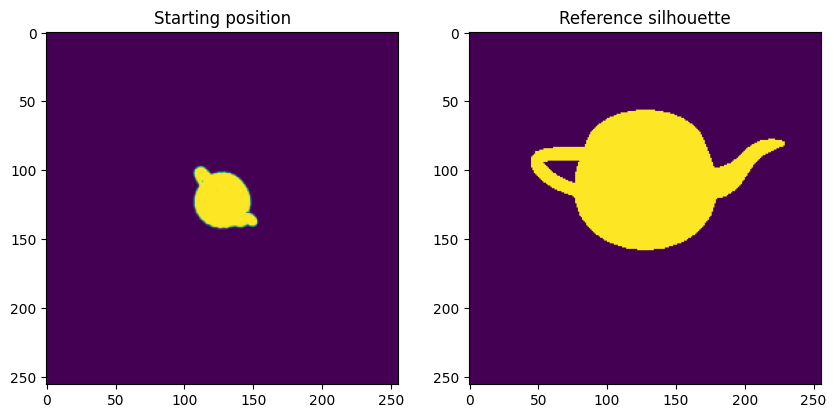

In [ ]:
plt.figure(figsize=(10, 10))

_, image_init, _ = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette");

## Run the optimization

In this part, we run the optimization loop that updates the camera position. Each iteration includes a forward pass to compute the rendered image and loss, followed by a backward pass to compute gradients. The optimizer then adjusts the camera position to reduce the loss.

The loop runs for up to 200 iterations or until the loss drops below 200. Every 10 iterations, the current camera position is used to render an RGB image with Phong shading. This image is saved into a GIF, allowing us to visualize the progress of the camera as it moves toward the optimal viewpoint.

This process gradually minimizes the difference between the rendered silhouette and the reference, effectively learning where the camera must be placed to match the reference image.

  0%|          | 0/400 [00:00<?, ?it/s]

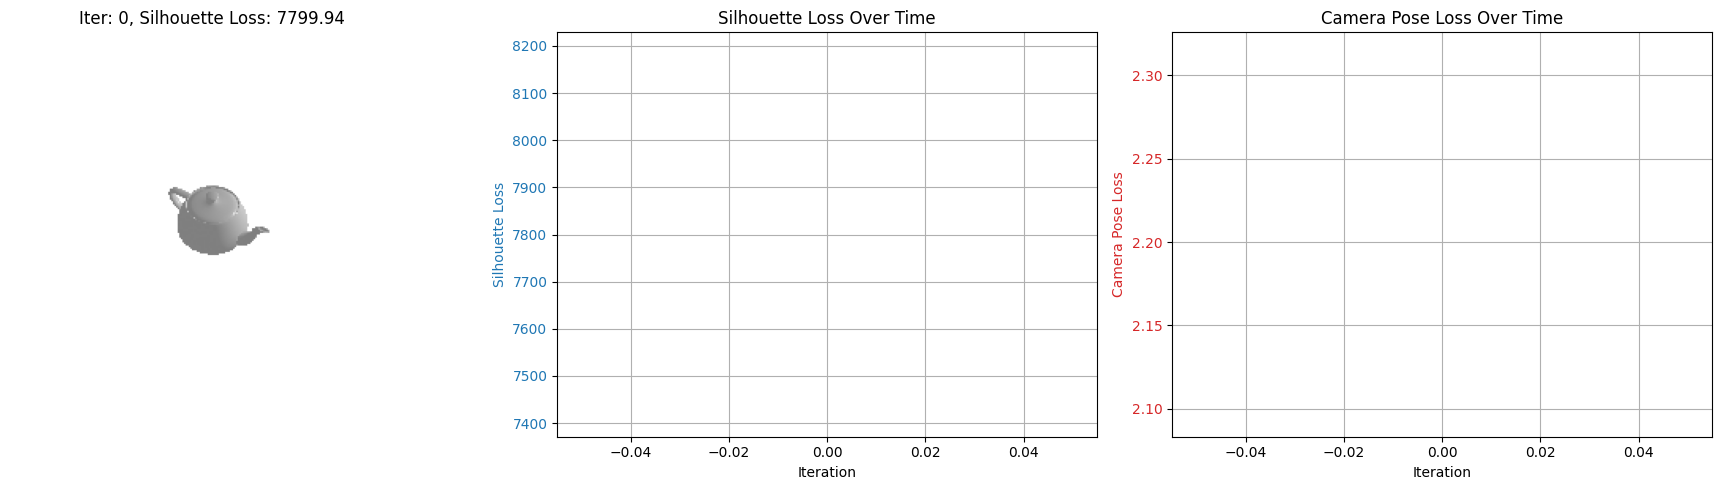

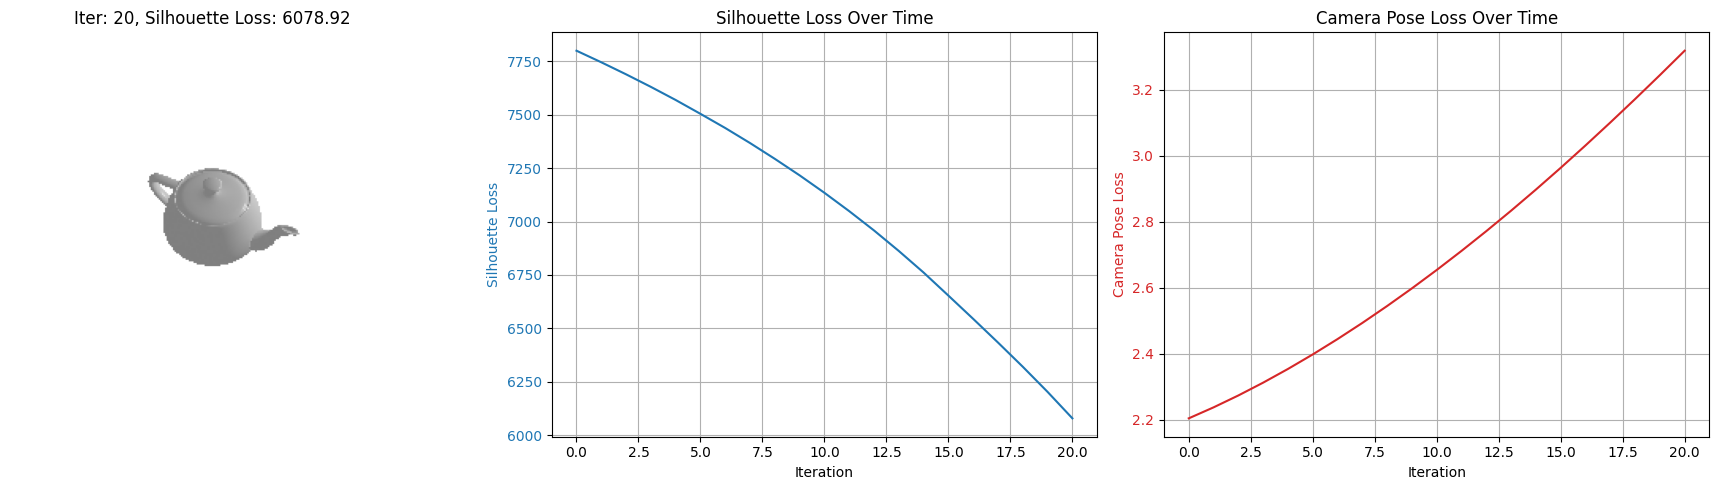

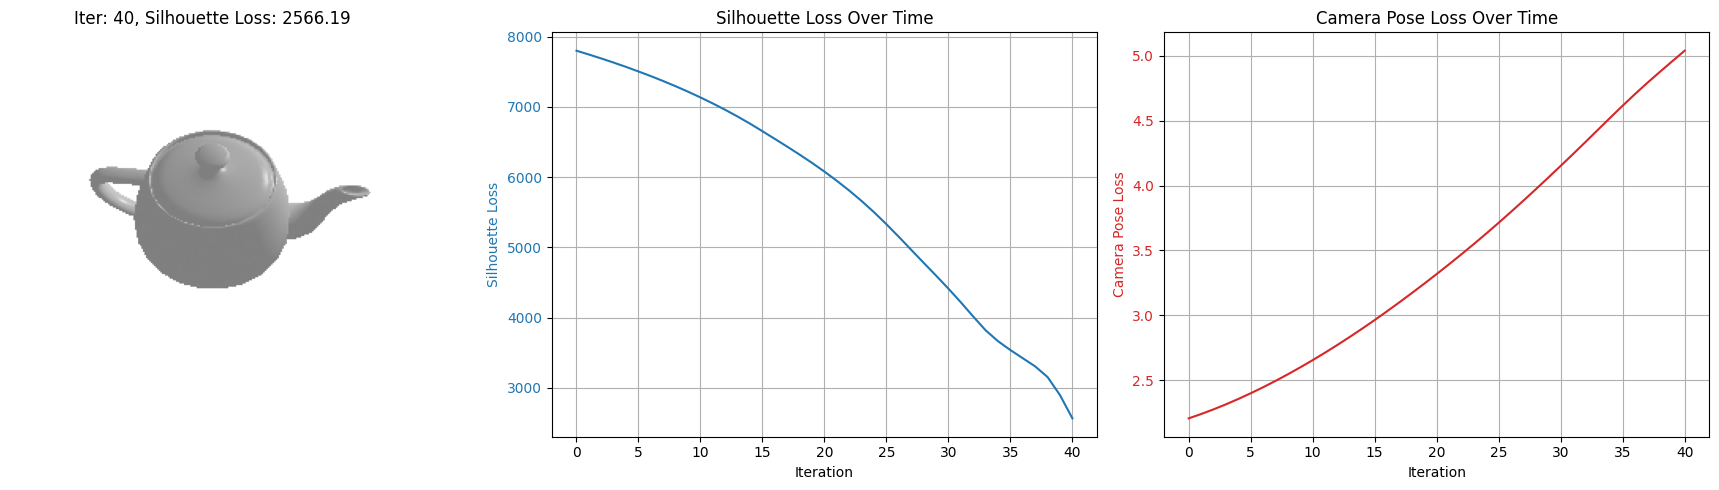

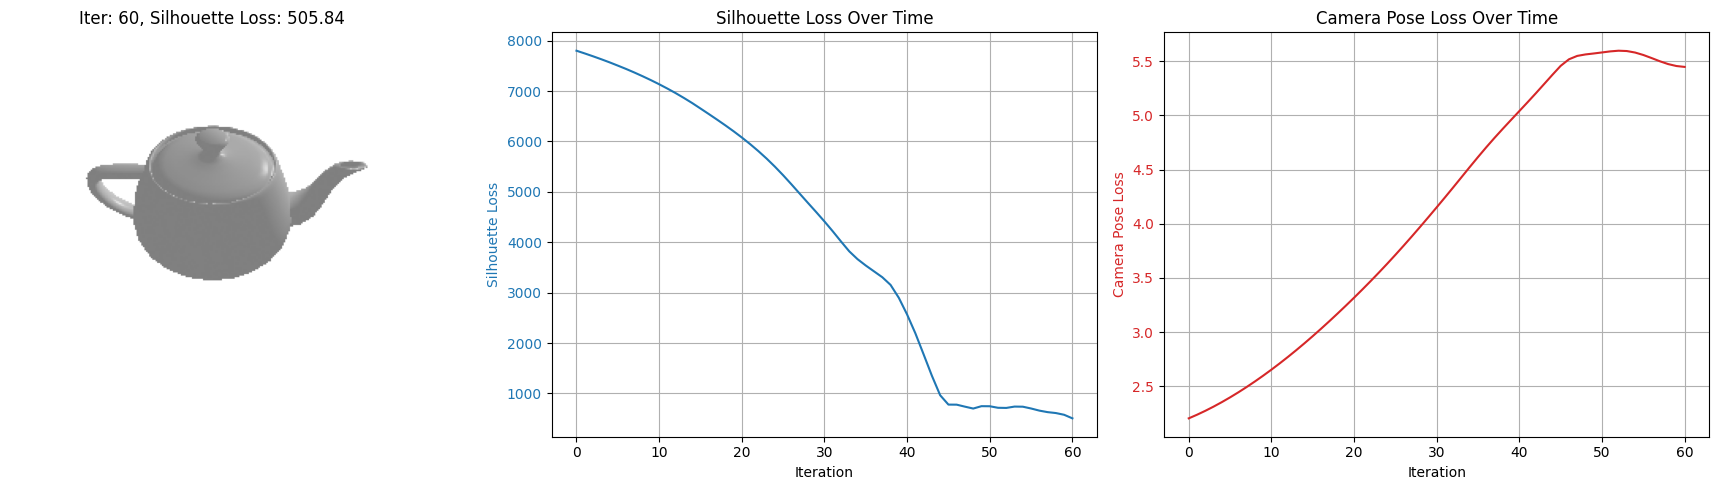

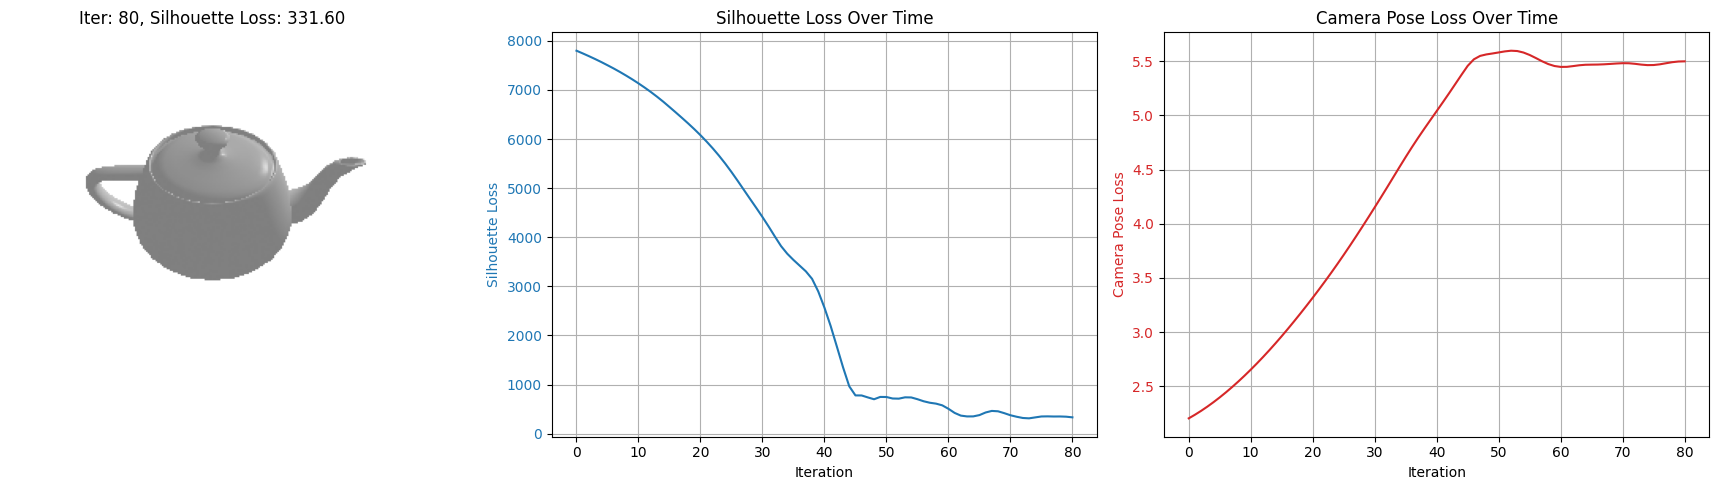

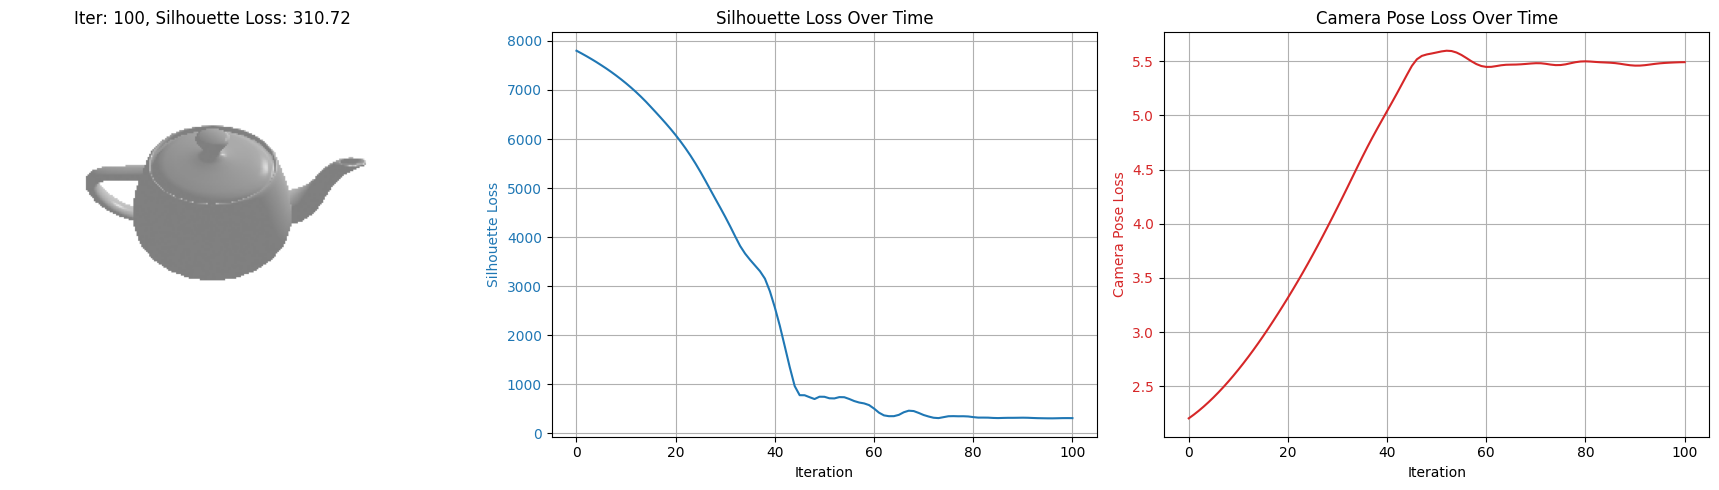

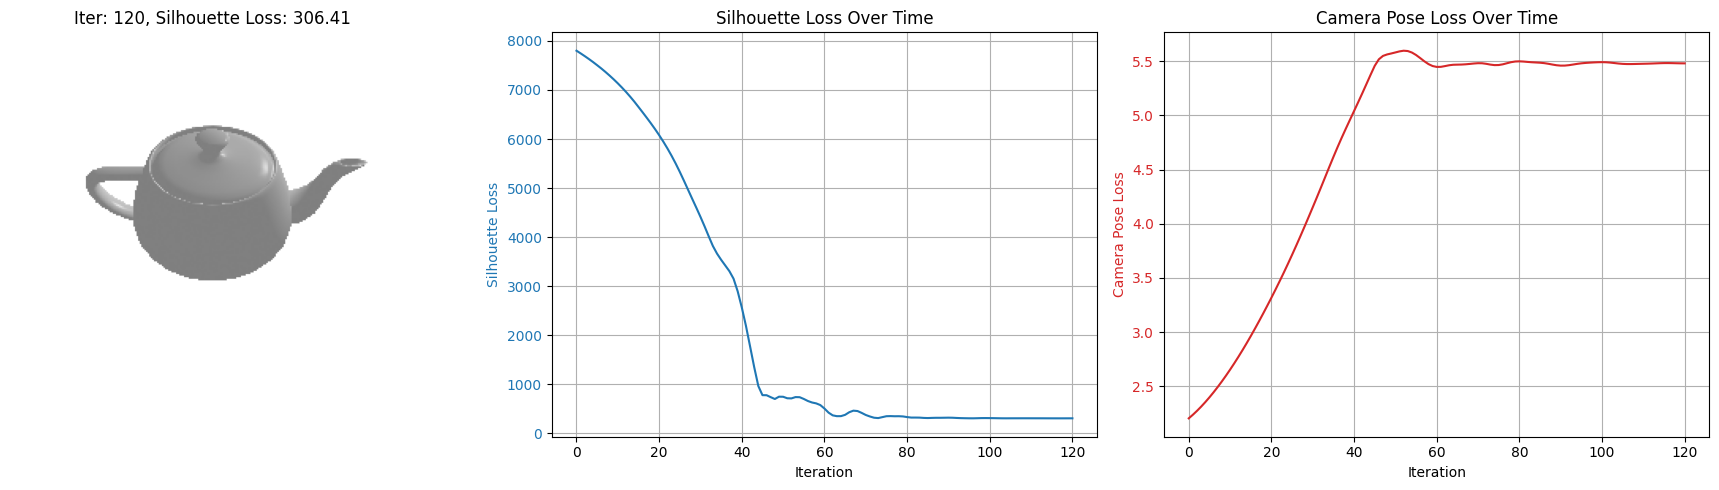

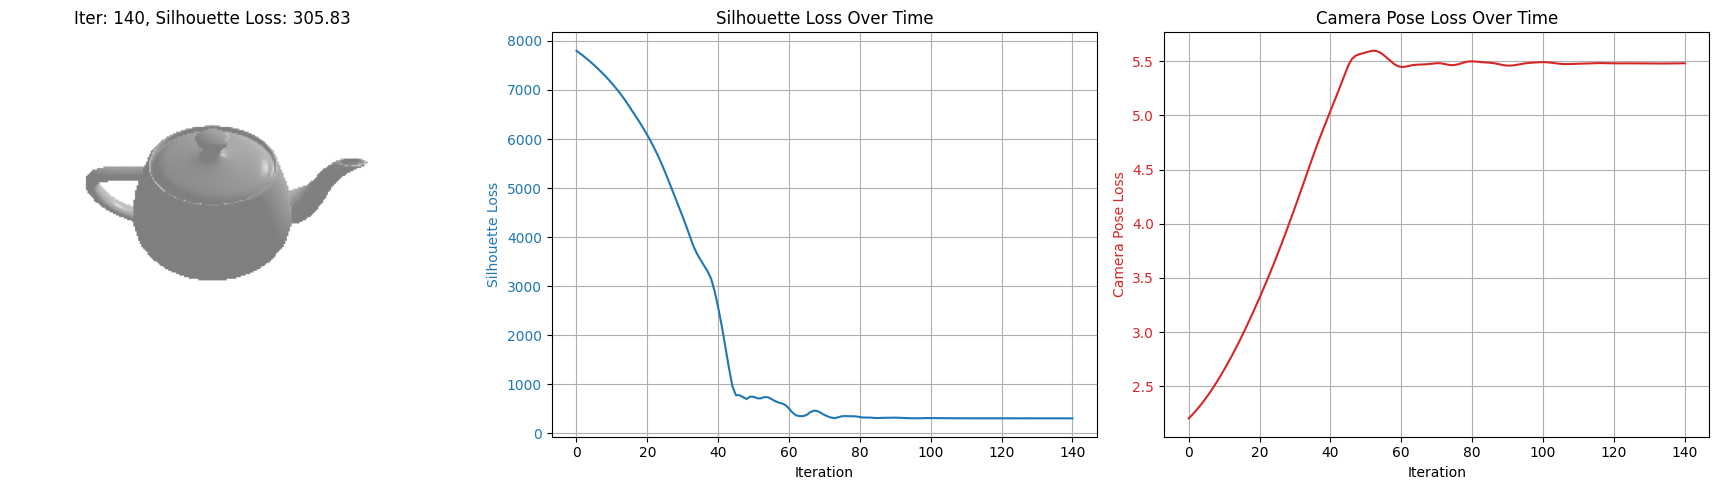

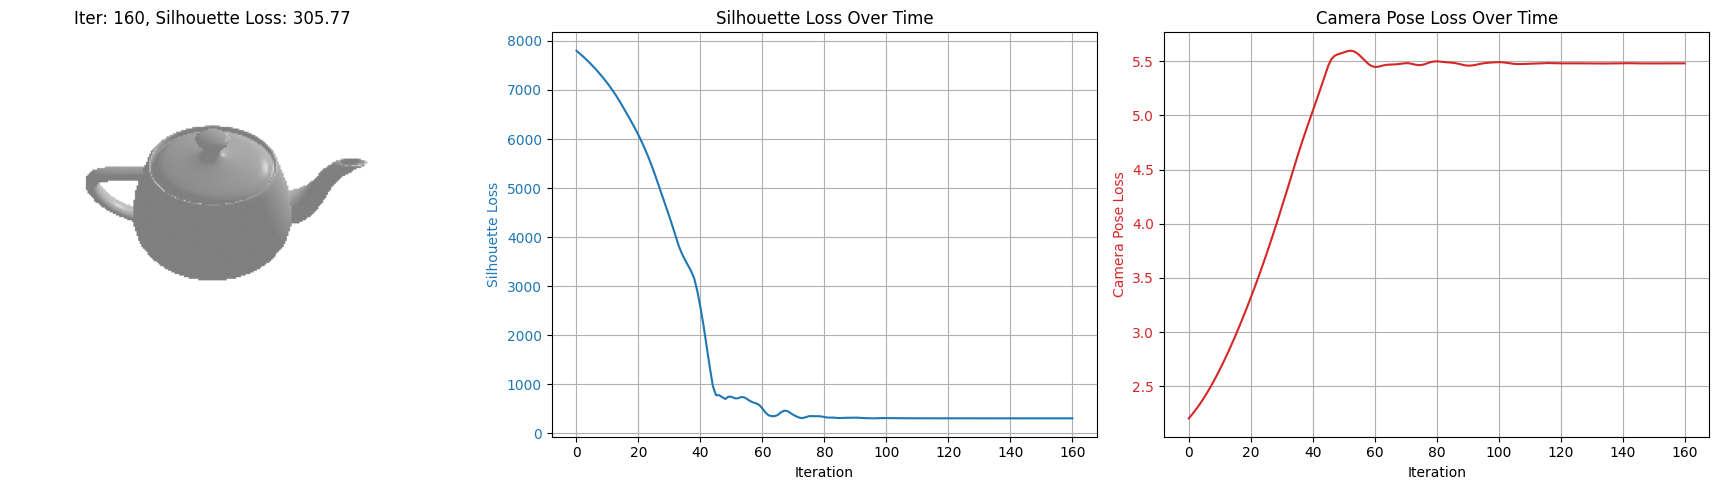

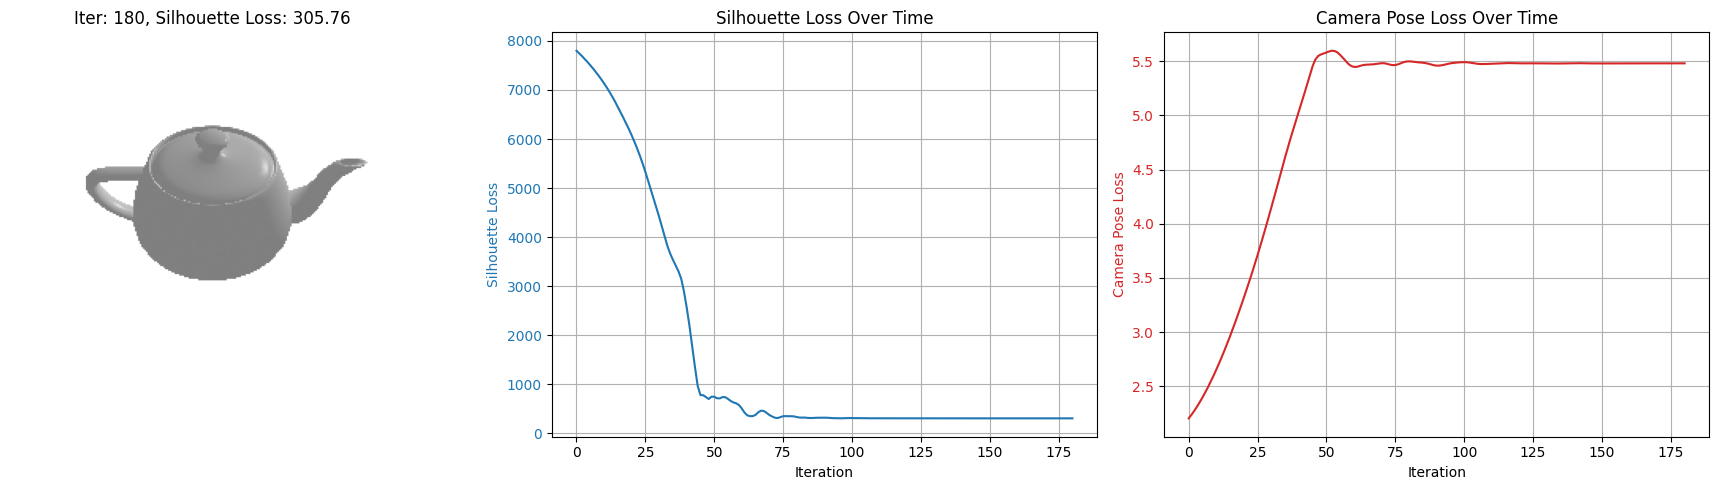

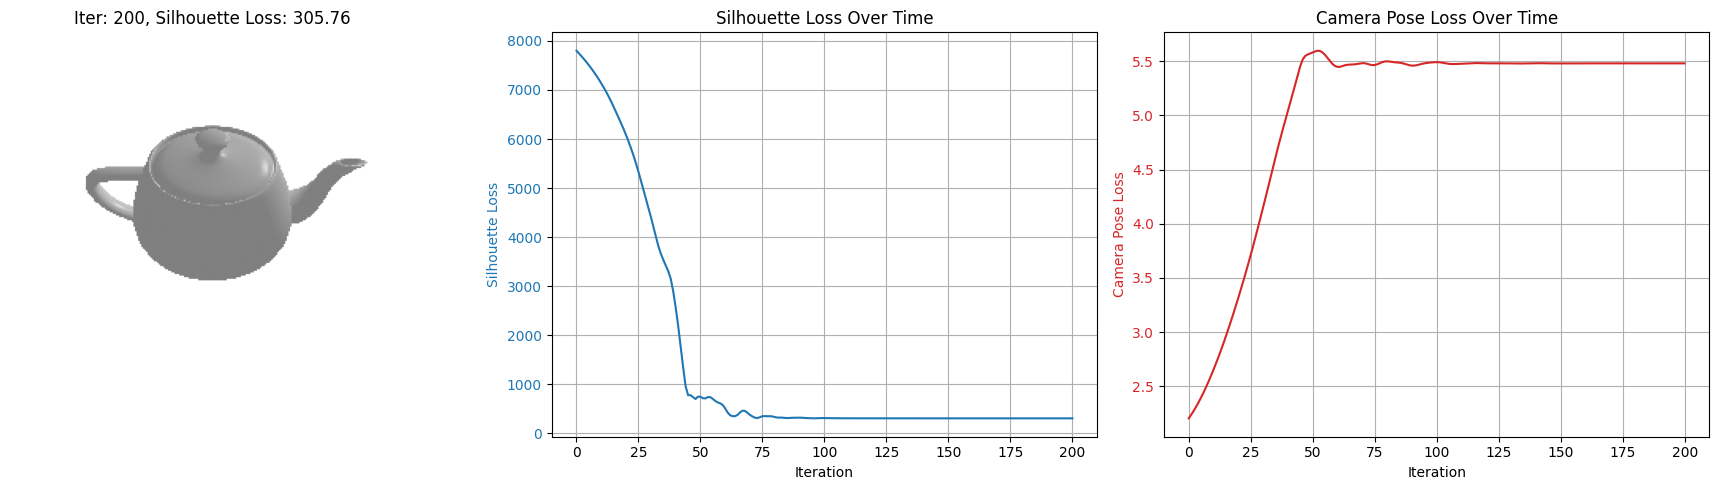

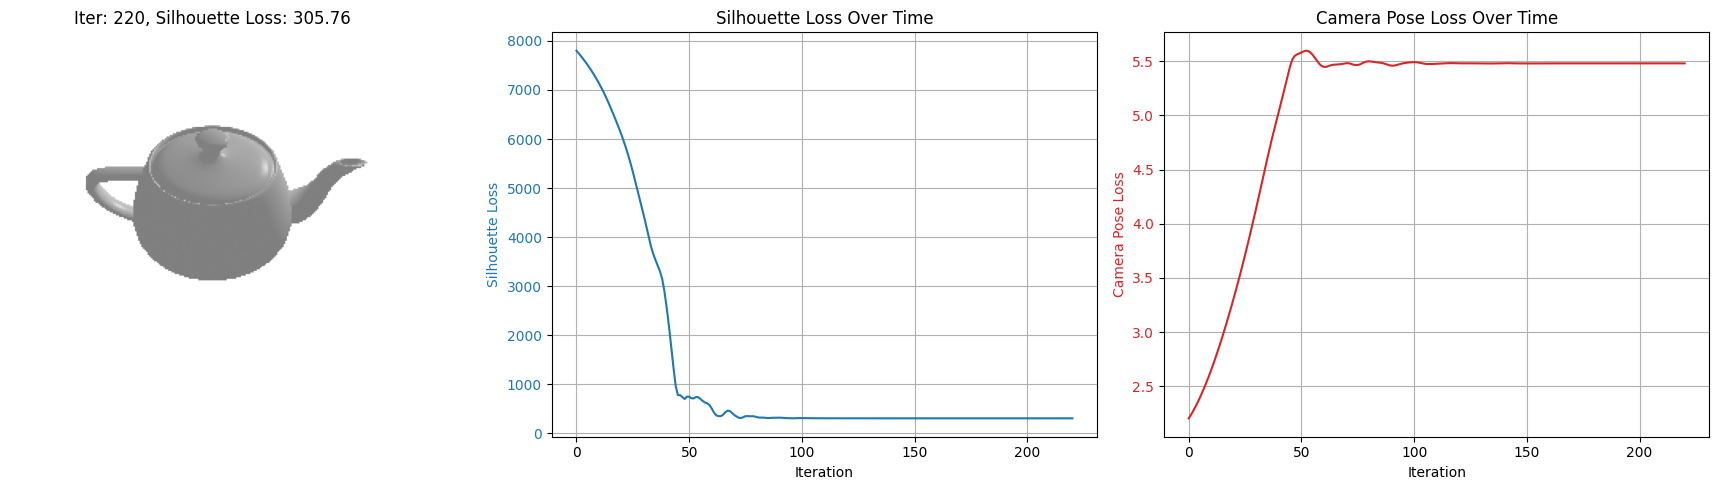

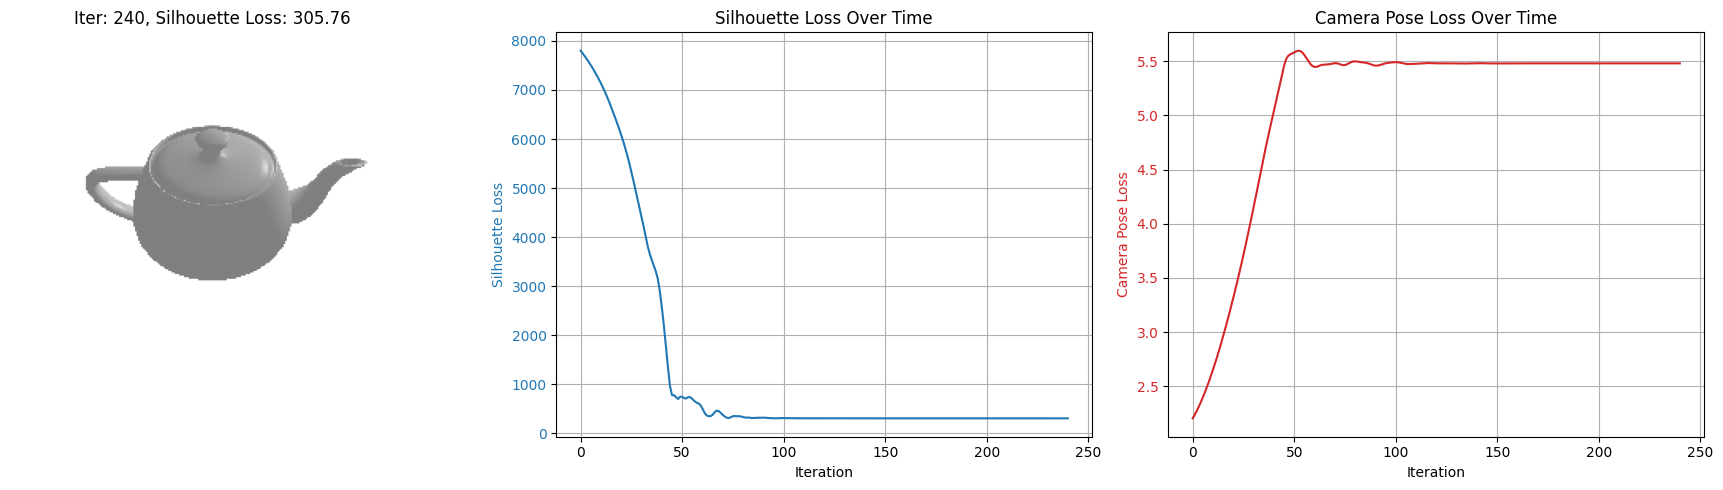

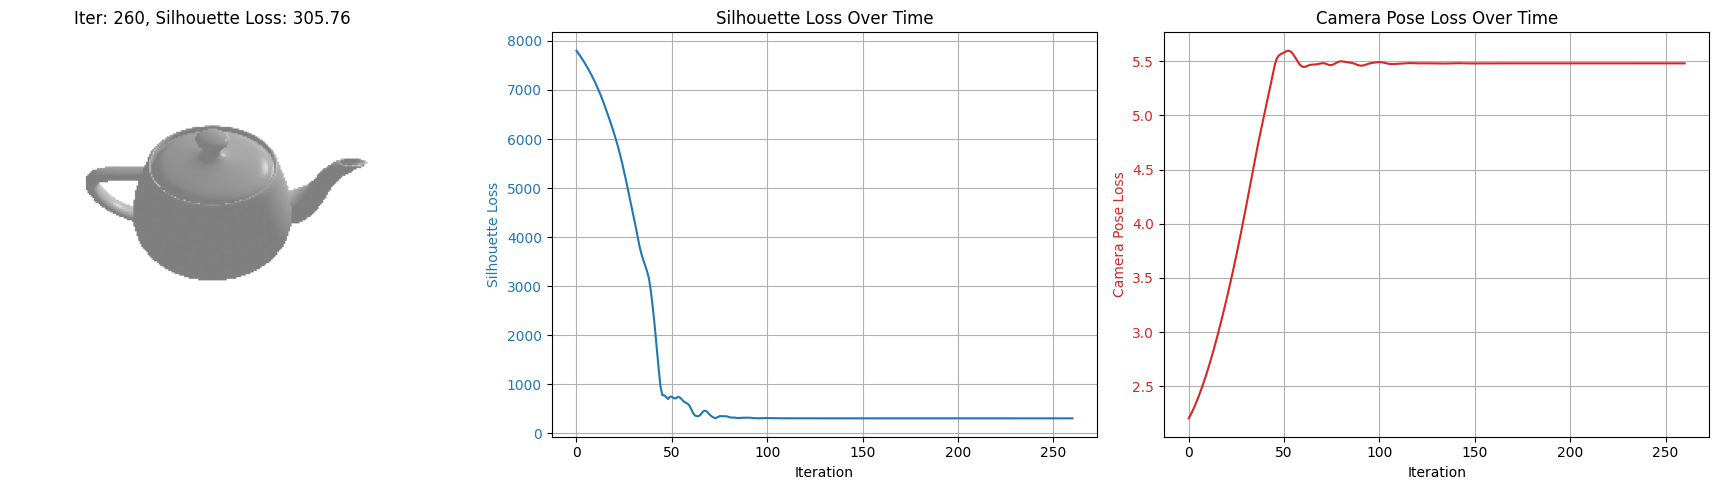

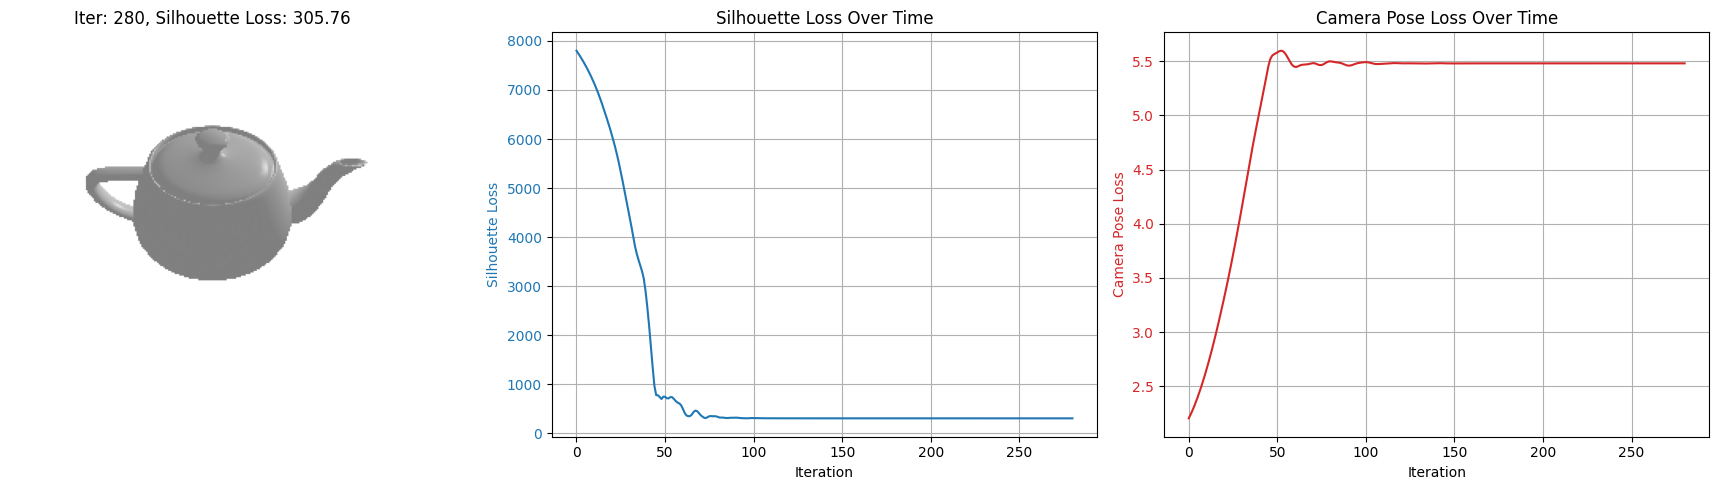

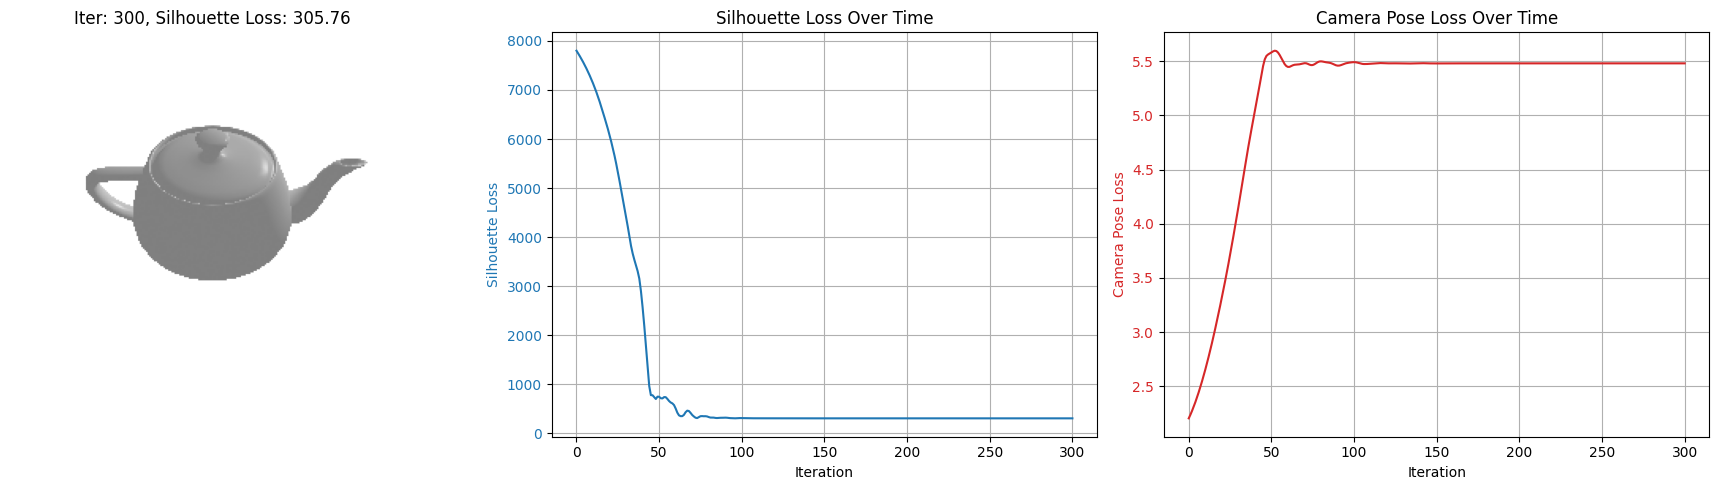

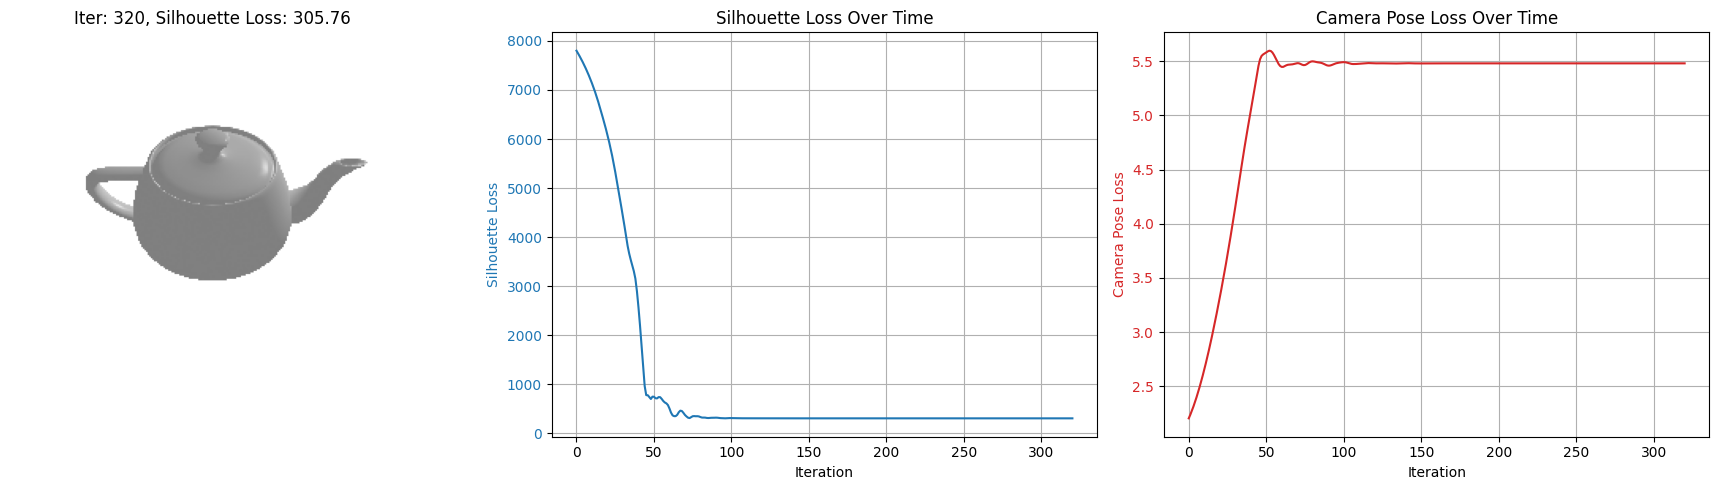

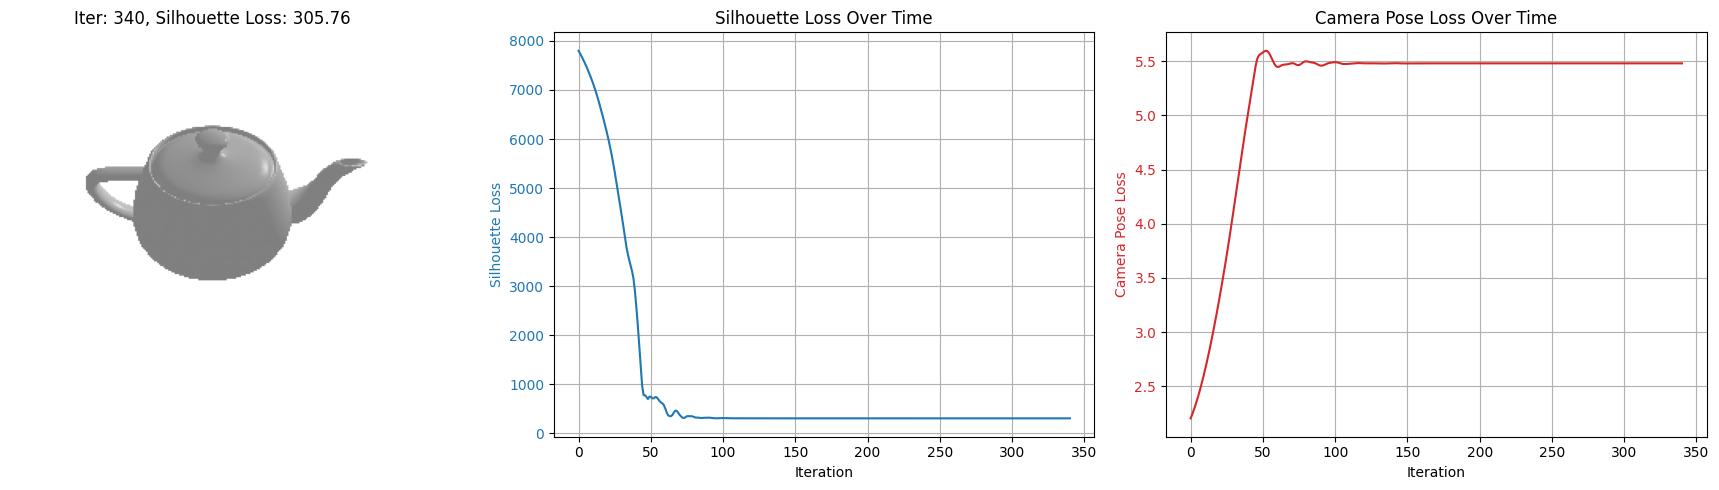

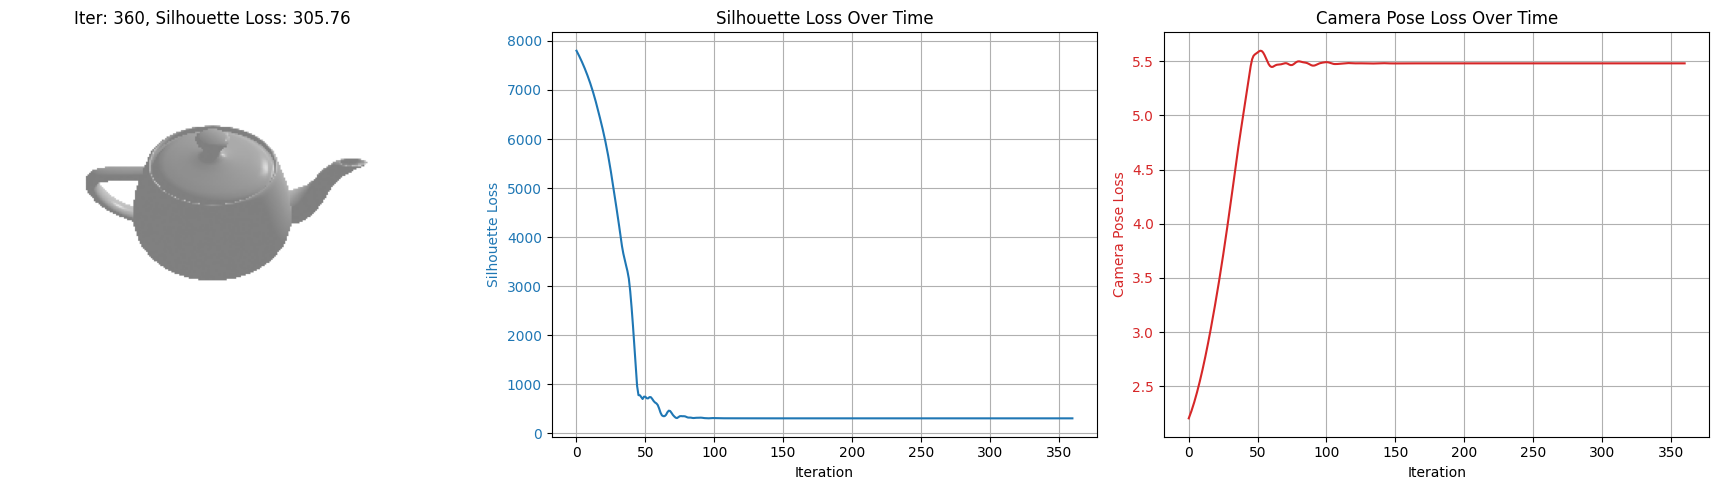

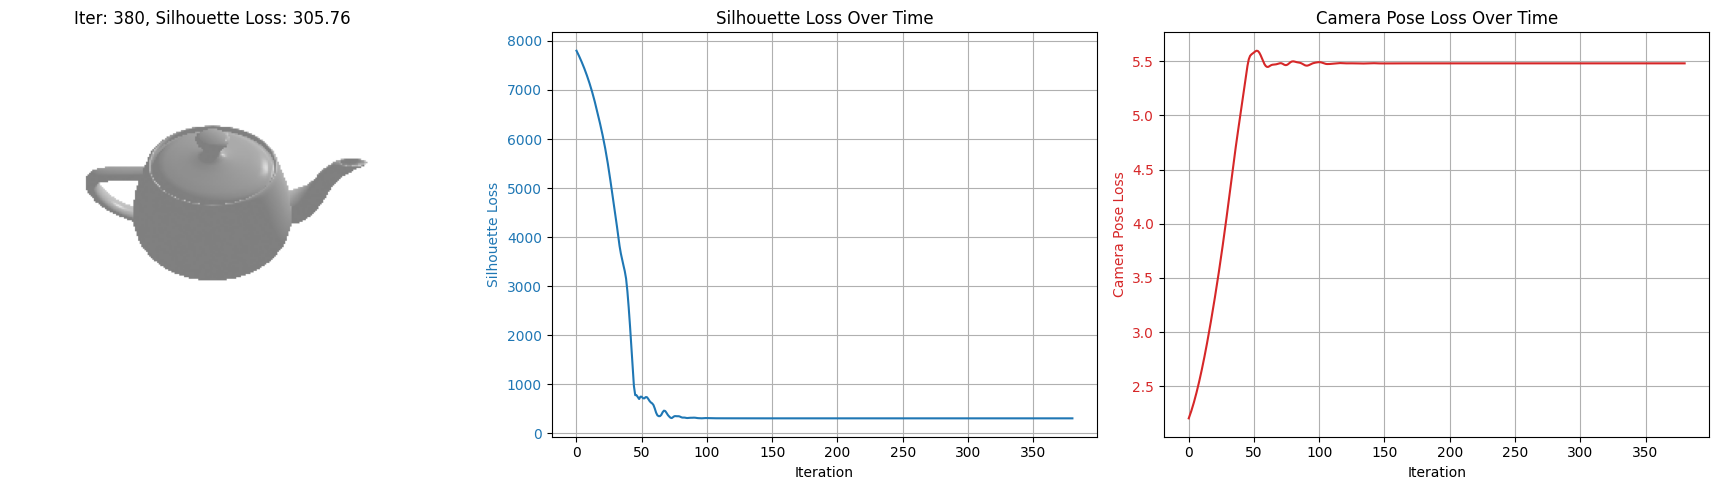

In [ ]:
silhouette_losses = []
pose_losses = []

loop = tqdm(range(400))
for i in loop:
    optimizer.zero_grad()
    loss, _, pose_loss = model()
    loss.backward()
    optimizer.step()

    silhouette_losses.append(loss.item())
    pose_losses.append(pose_loss.item())

    loop.set_description(f'Loss: {loss.item():.2f} | Pose Loss: {pose_loss.item():.2f}')

    if loss.item() < 200:
        break

    # Save outputs to create a GIF.
    if i % 20 == 0:
        R = look_at_rotation(model.camera_position[None, :], device=model.device)
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)

        fig, axs = plt.subplots(1, 3, figsize=(18, 5))

        # Rendered image
        axs[0].imshow(image[..., :3])
        axs[0].set_title(f"Iter: {i}, Silhouette Loss: {loss.item():.2f}")
        axs[0].axis("off")

        # Silhouette Loss
        axs[1].plot(silhouette_losses, label='Silhouette Loss', color='tab:blue')
        axs[1].set_xlabel("Iteration")
        axs[1].set_ylabel("Silhouette Loss", color='tab:blue')
        axs[1].tick_params(axis='y', labelcolor='tab:blue')
        axs[1].grid(True)
        axs[1].set_title("Silhouette Loss Over Time")

        # Pose Loss
        axs[2].plot(pose_losses, label='Camera Pose Loss [x, y, z]', color='tab:red')
        axs[2].set_xlabel("Iteration")
        axs[2].set_ylabel("Camera Pose Loss", color='tab:red')
        axs[2].tick_params(axis='y', labelcolor='tab:red')
        axs[2].grid(True)
        axs[2].set_title("Camera Pose Loss Over Time")

        plt.tight_layout()
        plt.show()

writer.close()